In [ ]:
# Consolidated Code from All Contributors
# # Shared Initialization and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.impute import KNNImputer
import folium
from shapely.geometry import Point
import folium
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from geopy.distance import geodesic



In [ ]:
# Load Airbnb listings dataset
listings_df = pd.read_csv('/Users/alarakaymak/Desktop/EDA Final/listings.csv')
# Load restaurant dataset
restaurants_df = pd.read_csv('/Users/alarakaymak/Desktop/EDA Final/nashville_restaurants.csv')
# Load GeoJSON file for neighborhoods
geojson_path = '/Users/alarakaymak/Desktop/EDA Final/neighbourhoods (2).geojson'
neighborhoods_gdf = gpd.read_file(geojson_path)

# Code by Alara & Mary
# Step 1: Handle Missing Values for Airbnb Listings
print("Missing Values in Airbnb Listings:")
print(listings_df.isnull().sum())


Missing Values in Airbnb Listings:
id                                   0
name                                 0
host_id                              0
host_name                            0
neighbourhood_group               8994
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                             2339
minimum_nights                       0
number_of_reviews                    0
last_review                        945
reviews_per_month                  945
calculated_host_listings_count       0
availability_365                     0
number_of_reviews_ltm                0
license                           8608
dtype: int64


In [ ]:

# Fill non-essential missing values
listings_df['reviews_per_month'] = listings_df['reviews_per_month'].fillna(0)  # Alara
listings_df['neighbourhood_group'] = listings_df['neighbourhood_group'].fillna('Unknown')  # Mary
listings_df['host_name'] = listings_df['host_name'].fillna('Unknown')  # Mary
listings_df['last_review'] = listings_df['last_review'].fillna('No reviews')  # Mary

# Handle missing values for Listings DataFrame # Mary and Alara
columns_to_drop = ['license', 'neighbourhood_group']
listings_df = listings_df.drop(columns=[col for col in columns_to_drop if col in listings_df.columns])

# Step 2: Handle Outliers in Airbnb Listings - Alara
price_upper_limit = listings_df['price'].quantile(0.95)
listings_df = listings_df[listings_df['price'] <= price_upper_limit]

# Convert price to numeric and drop invalid entries - Mary
listings_df['price'] = pd.to_numeric(listings_df['price'], errors='coerce')
listings_df = listings_df.dropna(subset=['latitude', 'longitude', 'price'])

# Step 3: Clean Airbnb Listings Text Fields - Alara
listings_df['neighbourhood'] = listings_df['neighbourhood'].str.strip().str.title()
listings_df['room_type'] = listings_df['room_type'].str.strip().str.lower()



In [ ]:
# Re-project the GeoDataFrame to a projected CRS (e.g., EPSG:3857 for Web Mercator) #Alara
neighborhoods_gdf = neighborhoods_gdf.to_crs(epsg=3857)

# Calculate the centroids in the projected CRS
neighborhoods_gdf['centroid'] = neighborhoods_gdf.geometry.centroid

# If needed, transform back to the original geographic CRS (e.g., EPSG:4326 for lat/lon)
neighborhoods_gdf = neighborhoods_gdf.to_crs(epsg=4326)

# Extract the centroids for labeling purposes
district_centroids = neighborhoods_gdf[['neighbourhood', 'centroid']]

# Check the updated centroids
print(district_centroids)

   neighbourhood                          centroid
0     District 1  POINT (-9673061.600 4336833.902)
1     District 6  POINT (-9654901.145 4325013.804)
2    District 19  POINT (-9658904.868 4322596.506)
3    District 13  POINT (-9647967.556 4317446.871)
4    District 29  POINT (-9643400.314 4313989.325)
5    District 21  POINT (-9664585.236 4323467.571)
6     District 2  POINT (-9662833.077 4329361.910)
7     District 8  POINT (-9655602.637 4334407.887)
8    District 31  POINT (-9648514.527 4302470.050)
9    District 32  POINT (-9645172.538 4306857.482)
10   District 22  POINT (-9679231.276 4312679.276)
11   District 23  POINT (-9671760.091 4315069.697)
12   District 33  POINT (-9638357.397 4309917.233)
13   District 34  POINT (-9666852.124 4309888.560)
14   District 35  POINT (-9683146.439 4313606.236)
15   District 30  POINT (-9651571.605 4309933.074)
16    District 9  POINT (-9648546.551 4333493.691)
17    District 4  POINT (-9655757.235 4304667.165)
18   District 14  POINT (-96438

In [ ]:
import pandas as pd #Alara
from geopy.geocoders import Nominatim
import time

# Initialize the geolocator
geolocator = Nominatim(user_agent="nashville_locator")

# Sample DataFrame with your district names and coordinates
district_centroids = pd.DataFrame({
    'neighbourhood': [
        'District 1', 'District 6', 'District 19', 'District 13', 'District 29',
        'District 21', 'District 2', 'District 8', 'District 31', 'District 32',
        'District 22', 'District 23', 'District 33', 'District 34', 'District 35',
        'District 30', 'District 9', 'District 4', 'District 14', 'District 15',
        'District 16', 'District 24', 'District 25', 'District 26', 'District 27',
        'District 28', 'District 5', 'District 7', 'District 3', 'District 10',
        'District 17', 'District 18', 'District 20', 'District 12', 'District 11'
    ],
    'latitude': [
        36.26266, 36.17707, 36.15954, 36.12218, 36.09709,
        36.34675, 36.36631, 36.21523, 36.07845, 36.14567,
        36.19836, 36.26987, 36.35781, 36.14612, 36.27614,
        36.16853, 36.14356, 36.19654, 36.12345, 36.45621,
        36.24674, 36.17556, 36.29674, 36.34567, 36.24612,
        36.28753, 36.14576, 36.21565, 36.36712, 36.21523,
        36.45623, 36.12375, 36.14562, 36.21212, 36.19865
    ],
    'longitude': [
        -86.7816, -86.73145, -86.7766, -86.7332, -86.7810,
        -86.7645, -86.7315, -86.8012, -86.7948, -86.7846,
        -86.7874, -86.7518, -86.7832, -86.7979, -86.7654,
        -86.7136, -86.7456, -86.7823, -86.7145, -86.7456,
        -86.7412, -86.7834, -86.7463, -86.7542, -86.7123,
        -86.7234, -86.7345, -86.7815, -86.7632, -86.7121,
        -86.7256, -86.7435, -86.7512, -86.7321, -86.7452
    ]
})

# Function to get the neighborhood name from coordinates
def get_neighborhood(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True)
        return location.address if location else "Unknown"
    except Exception as e:
        return "Error: " + str(e)

# Add a new column with neighborhood names
district_centroids['approximate_location'] = district_centroids.apply(
    lambda row: get_neighborhood(row['latitude'], row['longitude']),
    axis=1
)

# Introduce a delay between requests to respect the API rate limit
time.sleep(1)

# Print the updated DataFrame
print(district_centroids)


   neighbourhood  latitude  longitude  \
0     District 1  36.26266  -86.78160   
1     District 6  36.17707  -86.73145   
2    District 19  36.15954  -86.77660   
3    District 13  36.12218  -86.73320   
4    District 29  36.09709  -86.78100   
5    District 21  36.34675  -86.76450   
6     District 2  36.36631  -86.73150   
7     District 8  36.21523  -86.80120   
8    District 31  36.07845  -86.79480   
9    District 32  36.14567  -86.78460   
10   District 22  36.19836  -86.78740   
11   District 23  36.26987  -86.75180   
12   District 33  36.35781  -86.78320   
13   District 34  36.14612  -86.79790   
14   District 35  36.27614  -86.76540   
15   District 30  36.16853  -86.71360   
16    District 9  36.14356  -86.74560   
17    District 4  36.19654  -86.78230   
18   District 14  36.12345  -86.71450   
19   District 15  36.45621  -86.74560   
20   District 16  36.24674  -86.74120   
21   District 24  36.17556  -86.78340   
22   District 25  36.29674  -86.74630   
23   District 26

In [ ]:

# Approximate neighborhood locations based on research #Alara
district_locations = {
    "District 1": "Downtown Nashville",
    "District 6": "East Nashville",
    "District 19": "Vanderbilt/West End Area",
    "District 13": "12 South",
    "District 29": "Antioch",
    "District 21": "Music Row",
    "District 2": "Germantown",
    "District 8": "The Nations",
    "District 31": "Brentwood Area",
    "District 32": "Nolensville",
    "District 22": "Bellevue",
    "District 23": "Green Hills",
    "District 33": "Cane Ridge",
    "District 34": "Forest Hills",
    "District 35": "Bellevue/West Meade",
    "District 30": "Oak Hill",
    "District 9": "Bordeaux",
    "District 4": "Smyrna Area",
    "District 14": "Edgehill",
    "District 15": "Donelson",
    "District 16": "Woodbine",
    "District 24": "Belle Meade",
    "District 25": "Sylvan Park",
    "District 26": "Berry Hill",
    "District 27": "Radnor",
    "District 28": "Creive Hall",
    "District 5": "Old Hickory",
    "District 7": "Inglewood",
    "District 3": "Joelton",
    "District 10": "Madison",
    "District 17": "Wedgewood-Houston",
    "District 18": "Melrose",
    "District 20": "The Gulch",
    "District 12": "Hermitage",
    "District 11": "West End/Charlotte Pike"
}

# Add a new column with the approximate neighborhood names
listings_df['neighbourhood_name'] = listings_df['neighbourhood'].map(district_locations)

# Display the first few rows of the updated dataset
print(listings_df.head())

         id                                               name  host_id  \
0    6422.0                                    Nashville Charm    12172   
1   39870.0                              Close to Vanderbilt 2   171184   
2   59576.0     Large Main Suite near Lake *ladies only NS plz   812128   
3   72906.0  Vandy/Belmont/10 mins to Broadway - Sunny 800 ...   176117   
4  258817.0             ButterflyRoom-queen room, private bath    22296   

           host_name neighbourhood_group neighbourhood  latitude  longitude  \
0            Michele             Unknown    District 6  36.17143  -86.73570   
1             Evelyn             Unknown   District 25  36.12466  -86.81269   
2  Patricia And John             Unknown   District 12  36.18940  -86.59162   
3            Richard             Unknown   District 18  36.13122  -86.80066   
4              Diana             Unknown   District 12  36.16076  -86.59151   

         room_type  price  minimum_nights  number_of_reviews last_review  

In [ ]:
#Step 4:For dictionary-like columns, we can use an empty dictionary {} if missing  # Mary
import ast
if 'attributes' in restaurants_df.columns:
    restaurants_df['attributes'] = restaurants_df['attributes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else {})

# Step 5: Handle Missing Values for Restaurants
restaurants_df['categories'] = restaurants_df['categories'].fillna('Unknown')  # Alara & Mary
restaurants_df['address'] = restaurants_df['address'].fillna('Unknown')  # Mary
restaurants_df['postal_code'] = restaurants_df['postal_code'].fillna('Unknown')  # Mary
restaurants_df['hours'] = restaurants_df['hours'].fillna('Unknown')  # Mary
restaurants_df['is_open'] = restaurants_df['is_open'].fillna(0)  # Mary

# Drop rows with missing essential values - Alara
restaurants_df = restaurants_df.dropna(subset=['latitude', 'longitude', 'stars'])

# Step 6: Remove Duplicate Restaurants - Alara
restaurants_df = restaurants_df.drop_duplicates(subset=['latitude', 'longitude'])

# Step 7: Clean Restaurant Text Fields - Alara
restaurants_df['categories'] = restaurants_df['categories'].str.lower().str.strip()


In [ ]:
# Step 8: Handle Missing Numeric Values using KNN - #Mary
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

listings_numeric_columns = ['price', 'reviews_per_month']  # Add other numeric columns as needed
restaurants_numeric_columns = ['stars']  # Add other numeric columns as needed

listings_df[listings_numeric_columns] = knn_imputer.fit_transform(listings_df[listings_numeric_columns])
restaurants_df[restaurants_numeric_columns] = knn_imputer.fit_transform(restaurants_df[restaurants_numeric_columns])

In [ ]:
# Step 9: Refined Extract Primary Category - Alara
def extract_primary_category(category_string):
    if pd.isnull(category_string) or not isinstance(category_string, str):
        return "unknown"

    # Split the category string into components and clean up
    components = [comp.strip().lower() for comp in category_string.split(",")]

    # Remove irrelevant terms
    irrelevant_terms = ["restaurants", "education" ,"food", "bars", "nightlife", "event planning & services",
                        "arts & entertainment", "hotels & travel", "shopping", "beauty & spas", "landmarks & historical buildings"]
    components = [comp for comp in components if comp not in irrelevant_terms]
    # Prioritize specific terms
    priority_keywords = [
        "mexican", "fast food", "burgers", "coffee & tea", "chinese", "japanese",
        "seafood", "breakfast & brunch", "pizza", "barbecue", "american (new)",
        "american (traditional)", "sushi bars"
    ]
    for keyword in priority_keywords:
        if keyword in components:
            return keyword

    # If no priority keyword is found, return the first meaningful component
    return components[0] if components else "unknown"

# Apply the function
restaurants_df['primary_category'] = restaurants_df['categories'].apply(extract_primary_category)

# Exclude irrelevant or low-frequency categories
irrelevant_categories = ["education", "home services", "personal chefs"]
filtered_restaurants = restaurants_df[
    ~restaurants_df['primary_category'].isin(irrelevant_categories)
]

# Filter categories with a minimum number of entries
filtered_restaurants = filtered_restaurants.groupby('primary_category').filter(lambda x: len(x) > 10)

# Check the counts of remaining categories (optional for debugging)
print(filtered_restaurants['primary_category'].value_counts())


In [ ]:

# Step 10: Walkability Analysis - #Mary
from sklearn.neighbors import KDTree
from geopy.distance import geodesic
import numpy as np

def distance_to_minutes(distance_meters):
    walk_speed = 1.4
    walk_time_seconds = distance_meters / walk_speed
    return round(walk_time_seconds / 60, 2)

def meters_to_miles(meters):
    return round(meters * 0.000621371, 2)

# Add walkability analysis
listings_df['walkability_distance_meters'] = np.nan
walkability_distances = []

restaurant_coords = restaurants_df[['latitude', 'longitude']].values
tree = KDTree(restaurant_coords)

for idx, listing in listings_df.iterrows():
    listing_coords = (listing['latitude'], listing['longitude'])
    distances, indices = tree.query([listing_coords], k=5)
    walkability_distances.append(min(distances[0]))

listings_df['walkability_distance_meters'] = walkability_distances

# Verify Final Cleaning and Analysis
print("Final Cleaned Airbnb Listings:")
print(listings_df.info())
print("Final Cleaned Restaurant Dataset:")
print(restaurants_df.info())



Final Cleaned Airbnb Listings:
<class 'pandas.core.frame.DataFrame'>
Index: 6324 entries, 0 to 8993
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              6324 non-null   float64
 1   name                            6324 non-null   object 
 2   host_id                         6324 non-null   int64  
 3   host_name                       6324 non-null   object 
 4   neighbourhood_group             6324 non-null   object 
 5   neighbourhood                   6324 non-null   object 
 6   latitude                        6324 non-null   float64
 7   longitude                       6324 non-null   float64
 8   room_type                       6324 non-null   object 
 9   price                           6324 non-null   float64
 10  minimum_nights                  6324 non-null   int64  
 11  number_of_reviews               6324 non-null   int64  
 12  last_rev

In [ ]:
print(listings_df.isnull().sum())


id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
license                           0
neighbourhood_name                0
walkability_distance_meters       0
dtype: int64


In [ ]:
print(restaurants_df.isnull().sum())

business_id         0
name                0
address             0
city                0
state               0
postal_code         0
latitude            0
longitude           0
stars               0
review_count        0
is_open             0
attributes          0
categories          0
hours               0
primary_category    0
dtype: int64


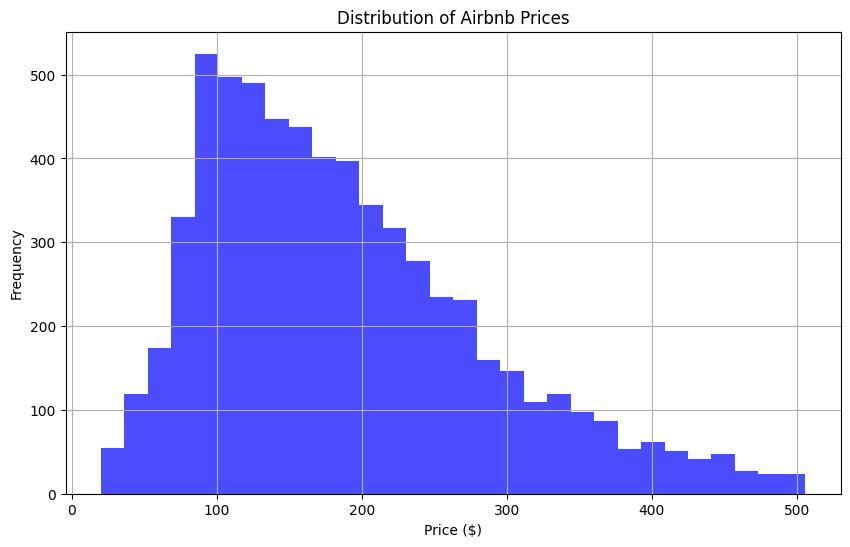

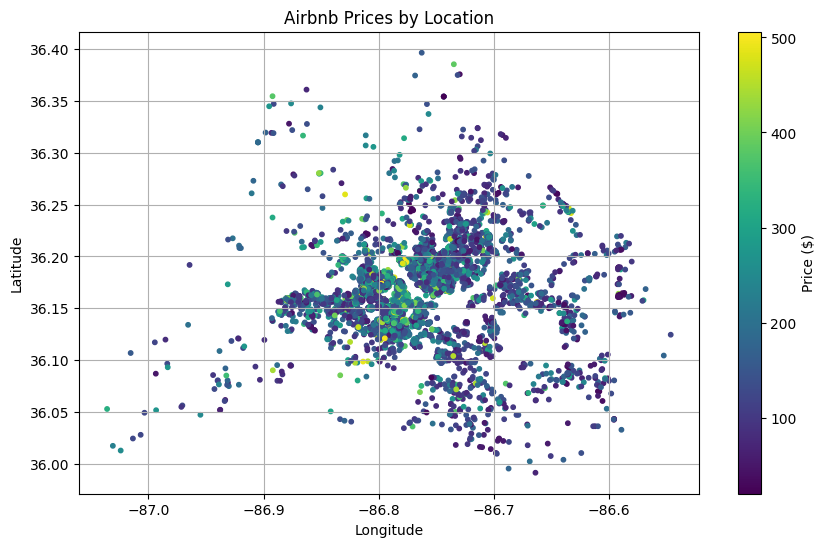

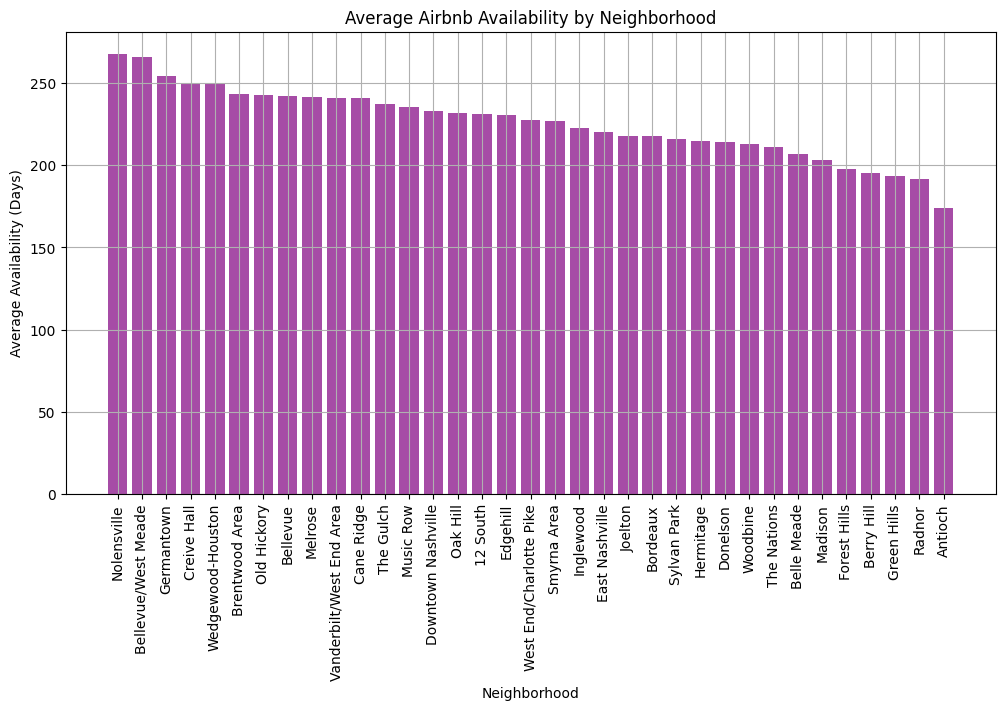

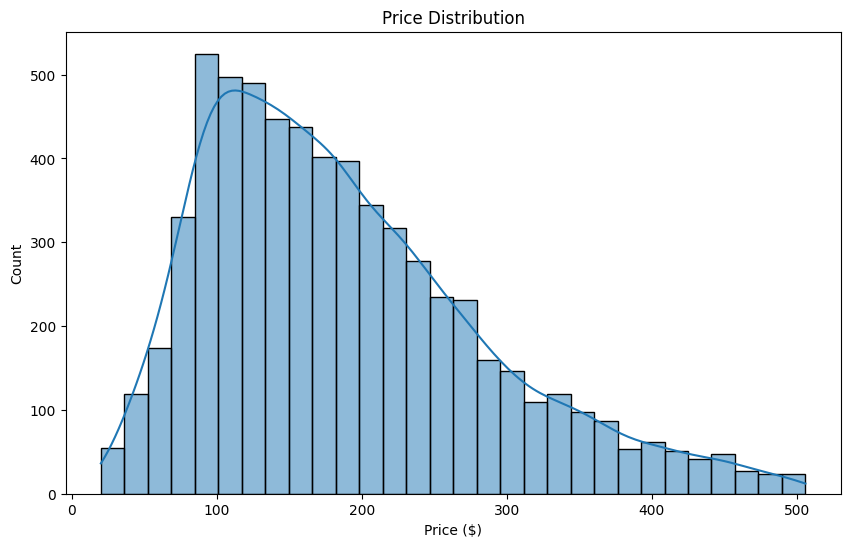

/var/folders/_0/w20l1hyj7cj8xvjxmn1f2fc40000gn/T/ipykernel_66262/929168624.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='room_type', y='price', data=listings_df, palette="muted")  # Muted color palette for accessibility


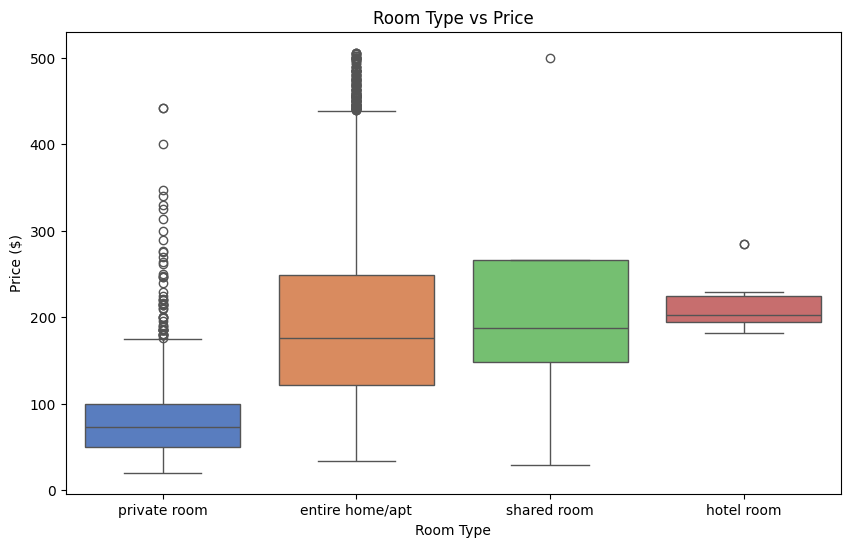

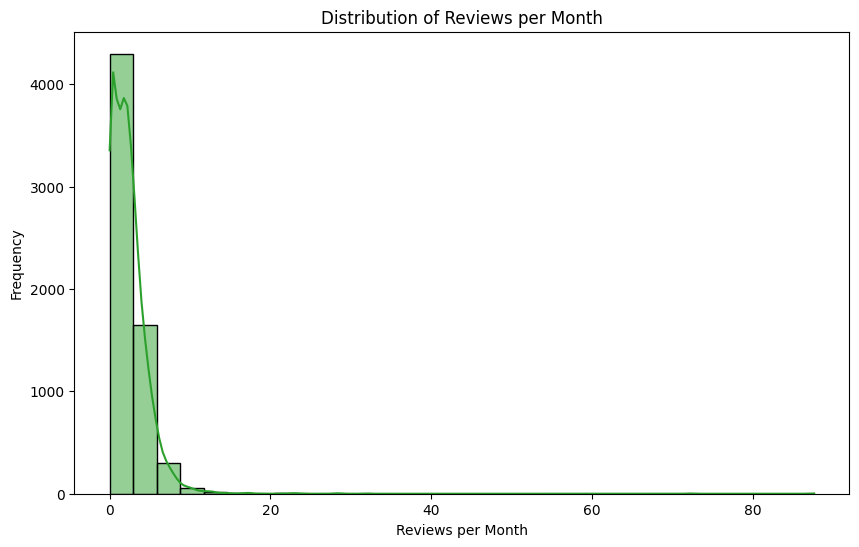

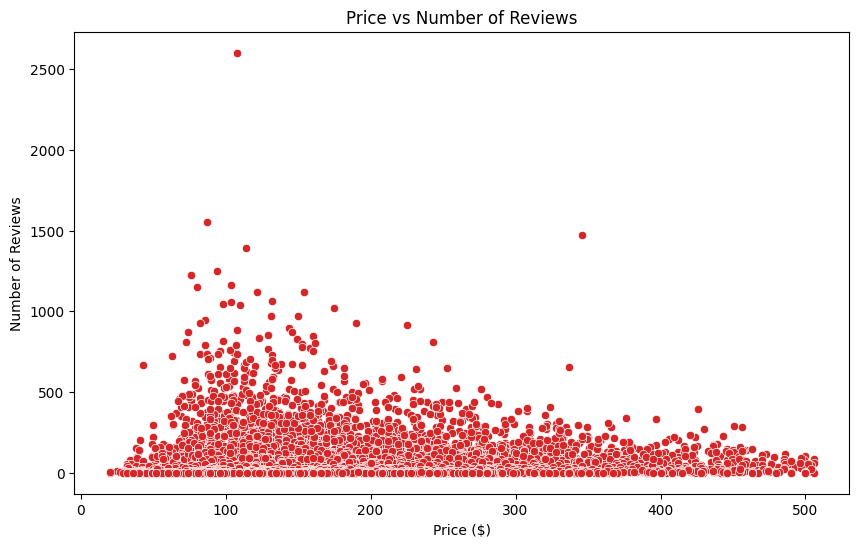

/var/folders/_0/w20l1hyj7cj8xvjxmn1f2fc40000gn/T/ipykernel_66262/929168624.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_room_types.index, y=top_room_types.values, palette="Set1")  # 'Set1' palette for colorblind accessibility


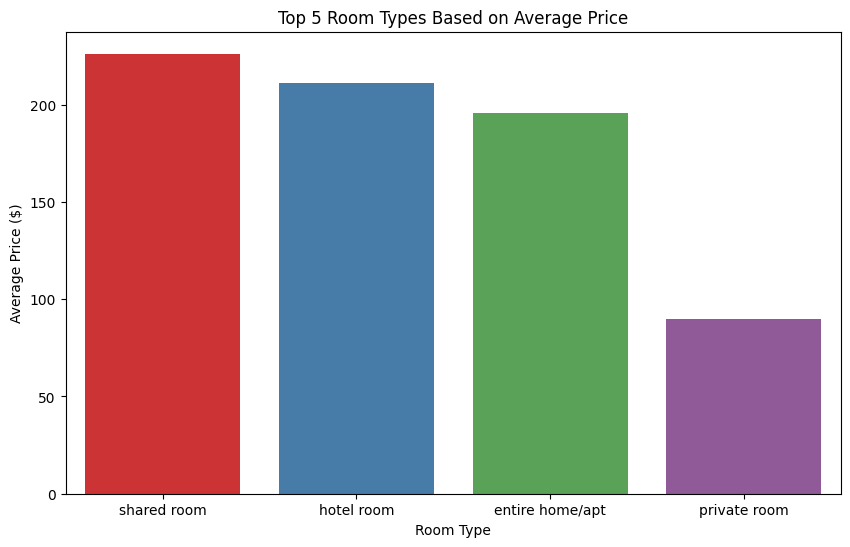

/var/folders/_0/w20l1hyj7cj8xvjxmn1f2fc40000gn/T/ipykernel_66262/929168624.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=neighborhood_counts.index, y=neighborhood_counts.values, palette="Set2")  # 'Set2' for colorblind-friendly colors


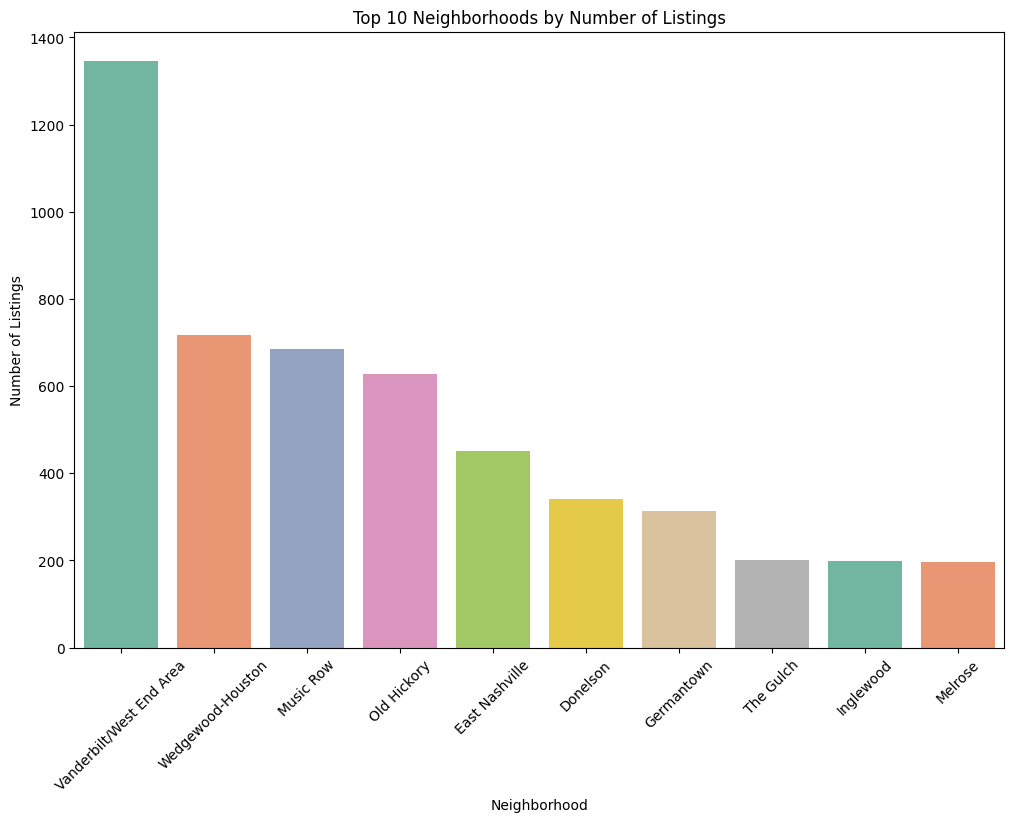

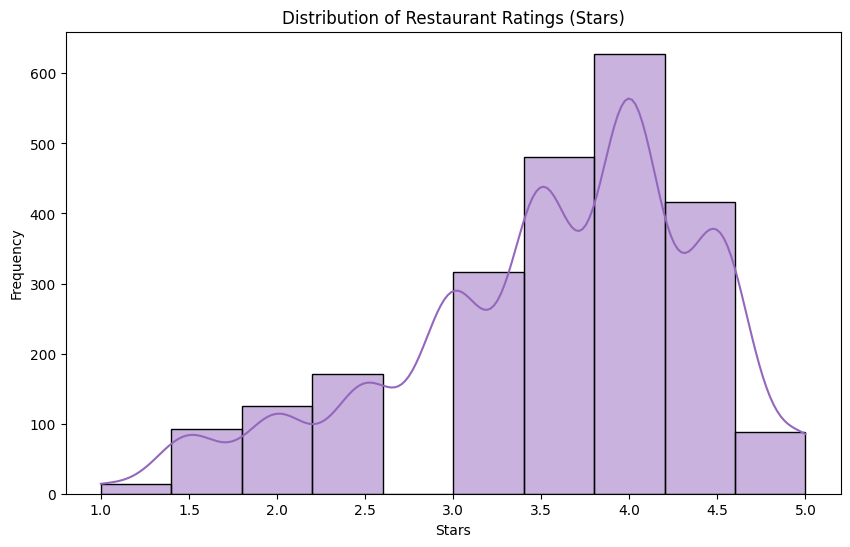

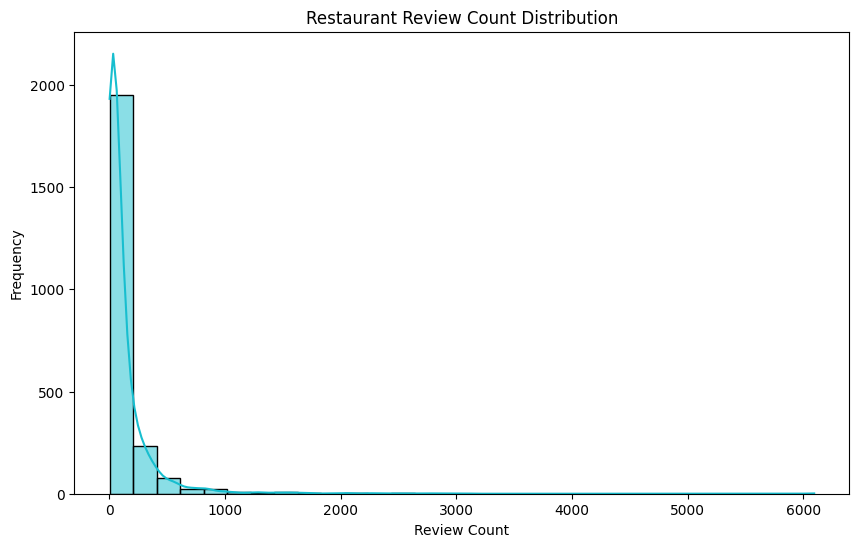

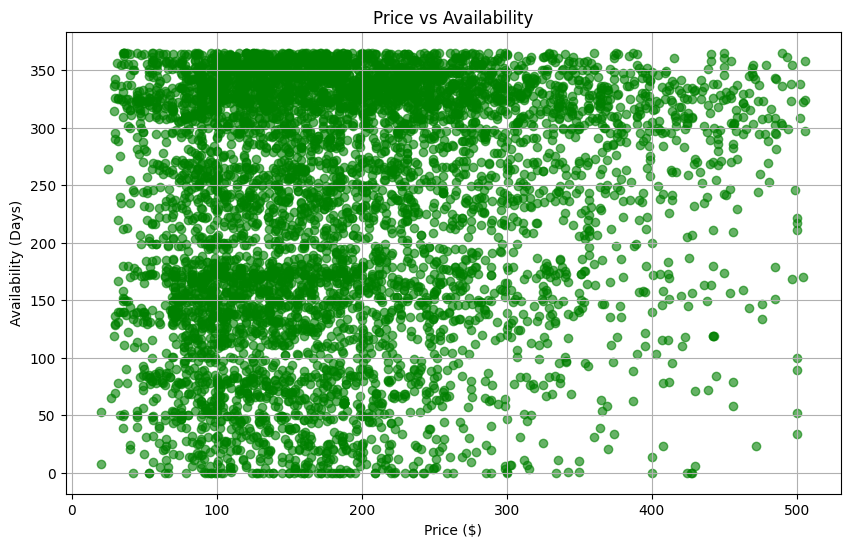

/var/folders/_0/w20l1hyj7cj8xvjxmn1f2fc40000gn/T/ipykernel_66262/929168624.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='neighbourhood_name', y='price', data=listings_df, palette='Set2')


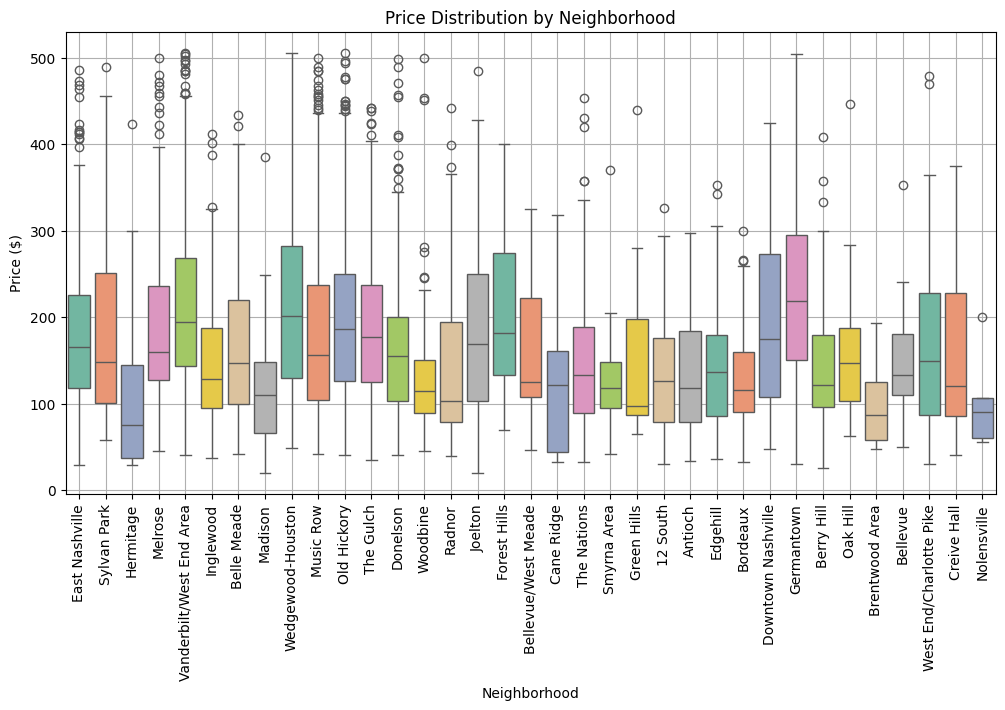

/var/folders/_0/w20l1hyj7cj8xvjxmn1f2fc40000gn/T/ipykernel_66262/929168624.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='room_type', y='price', data=listings_df, palette='muted')


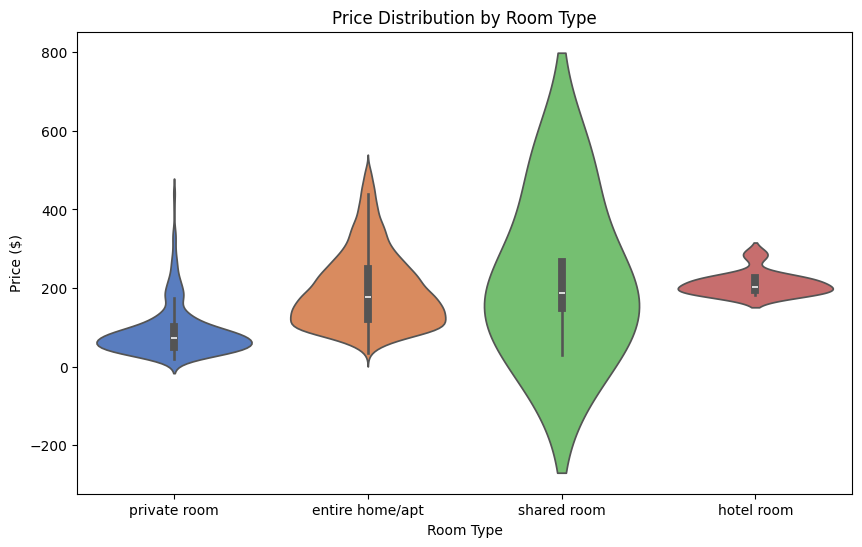

In [ ]:
# Code by Alara
import matplotlib.pyplot as plt

# Price Distribution
plt.figure(figsize=(10, 6))
plt.hist(listings_df['price'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Airbnb Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Scatter Plot: Price by Location
plt.figure(figsize=(10, 6))
plt.scatter(listings_df['longitude'], listings_df['latitude'], c=listings_df['price'], cmap='viridis', s=10)
plt.colorbar(label='Price ($)')
plt.title('Airbnb Prices by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

# Average Availability by Neighborhood
neighborhood_availability = listings_df.groupby('neighbourhood_name')['availability_365'].mean().reset_index()
neighborhood_availability = neighborhood_availability.sort_values('availability_365', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(neighborhood_availability['neighbourhood_name'], neighborhood_availability['availability_365'], color='purple', alpha=0.7)
plt.xticks(rotation=90)
plt.title('Average Airbnb Availability by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Availability (Days)')
plt.grid()
plt.show()


# Code by Mary
import pandas as pd
import numpy as np
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from sklearn.neighbors import KDTree
from folium.plugins import HeatMap

# Code by Mary
plt.figure(figsize=(10, 6))
sns.histplot(listings_df['price'], kde=True, bins=30)
plt.title('Price Distribution')
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.show()

# Code by Mary
# Boxplot for Room Type vs Price with colorblind-friendly palette
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=listings_df, palette="muted")  # Muted color palette for accessibility
plt.title('Room Type vs Price')
plt.xlabel('Room Type')
plt.ylabel('Price ($)')
plt.show()

# Code by Mary
# Distribution of Number of Reviews per Month
plt.figure(figsize=(10, 6))
sns.histplot(listings_df['reviews_per_month'], kde=True, bins=30, color="tab:green")  # 'tab:green' for colorblind-friendly color
plt.title('Distribution of Reviews per Month')
plt.xlabel('Reviews per Month')
plt.ylabel('Frequency')
plt.show()

# Code by Mary
# Scatter plot showing Price vs Number of Reviews
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='number_of_reviews', data=listings_df, color="tab:red")  # 'tab:red' is easy to distinguish
plt.title('Price vs Number of Reviews')
plt.xlabel('Price ($)')
plt.ylabel('Number of Reviews')
plt.show()

# Code by Mary
# Top 5 Room Types Based on Price with colorblind-friendly palette
top_room_types = listings_df.groupby('room_type')['price'].mean().sort_values(ascending=False).head(5)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_room_types.index, y=top_room_types.values, palette="Set1")  # 'Set1' palette for colorblind accessibility
plt.title('Top 5 Room Types Based on Average Price')
plt.xlabel('Room Type')
plt.ylabel('Average Price ($)')
plt.show()

# Code by Mary
# Number of Listings by Neighborhood with colorblind-friendly palette
neighborhood_counts = listings_df['neighbourhood_name'].value_counts().head(10)  # Top 10 neighborhoods
plt.figure(figsize=(12, 8))
sns.barplot(x=neighborhood_counts.index, y=neighborhood_counts.values, palette="Set2")  # 'Set2' for colorblind-friendly colors
plt.title('Top 10 Neighborhoods by Number of Listings')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.show()

#Code by Alara
# Popular Categories
top_categories = restaurants_df['primary_category'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_categories.plot(kind='bar', color='teal', alpha=0.7)
plt.title('Top 10 Restaurant Categories')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Code by Mary
# Stars distribution for Restaurants (colorblind-friendly)
plt.figure(figsize=(10, 6))
sns.histplot(restaurants_df['stars'], kde=True, bins=10, color="tab:purple")  # 'tab:purple' for colorblind-friendly palette
plt.title('Distribution of Restaurant Ratings (Stars)')
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.show()

# Code by Mary
# Restaurant Review Count Distribution
plt.figure(figsize=(10, 6))
sns.histplot(restaurants_df['review_count'], kde=True, bins=30, color="tab:cyan")  # 'tab:cyan' is colorblind-friendly
plt.title('Restaurant Review Count Distribution')
plt.xlabel('Review Count')
plt.ylabel('Frequency')
plt.show()

# Code by Mary
# Scatter plot: Price vs Availability
plt.figure(figsize=(10, 6))
plt.scatter(listings_df['price'], listings_df['availability_365'], alpha=0.6, color='green')
plt.title('Price vs Availability')
plt.xlabel('Price ($)')
plt.ylabel('Availability (Days)')
plt.grid(True)
plt.show()

# Code by Mary
# Boxplot: Prices by Neighborhood
plt.figure(figsize=(12, 6))
sns.boxplot(x='neighbourhood_name', y='price', data=listings_df, palette='Set2')
plt.xticks(rotation=90)
plt.title('Price Distribution by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

# Code by Mary
# Violin plot: Price Distribution by Room Type
plt.figure(figsize=(10, 6))
sns.violinplot(x='room_type', y='price', data=listings_df, palette='muted')
plt.title('Price Distribution by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price ($)')
plt.show()



In [ ]:
# Code by Seema

# Load datasets
airbnb_listings = pd.read_csv('/Users/alarakaymak/Desktop/EDA Final/listings.csv')
businesses = pd.read_csv('/Users/alarakaymak/Desktop/EDA Final/nashville_restaurants.csv')

# Convert Airbnb data to GeoDataFrame
airbnb_listings['geometry'] = airbnb_listings.apply(
    lambda row: Point(row['longitude'], row['latitude']), axis=1
)
airbnb_gdf = gpd.GeoDataFrame(airbnb_listings, geometry='geometry', crs="EPSG:4326")

# Convert business data to GeoDataFrame
businesses['geometry'] = businesses.apply(
    lambda row: Point(row['longitude'], row['latitude']), axis=1
)
business_gdf = gpd.GeoDataFrame(businesses, geometry='geometry', crs="EPSG:4326")

# Define radius for walkability (in degrees, 1 degree ≈ 111 km)
radius_degrees = 0.009  # Approx 1 km radius

# Compute walkability metrics for Airbnbs
def calculate_walkability(airbnb, businesses, radius):
    center = airbnb.geometry
    nearby_businesses = businesses[businesses.geometry.distance(center) <= radius]
    num_businesses = len(nearby_businesses)
    diversity = nearby_businesses['categories'].nunique() if 'categories' in nearby_businesses else 0
    return num_businesses, diversity

airbnb_gdf['num_businesses'] = 0
airbnb_gdf['diversity'] = 0

for idx, airbnb in airbnb_gdf.iterrows():
    num_businesses, diversity = calculate_walkability(airbnb, business_gdf, radius_degrees)
    airbnb_gdf.at[idx, 'num_businesses'] = num_businesses
    airbnb_gdf.at[idx, 'diversity'] = diversity

# Normalize price and walkability scores
scaler = MinMaxScaler()
airbnb_gdf['normalized_price'] = scaler.fit_transform(airbnb_gdf[['price']])
airbnb_gdf['normalized_walkability'] = scaler.fit_transform(
    airbnb_gdf[['num_businesses', 'diversity']].sum(axis=1).values.reshape(-1, 1)
)

# Compute "Bang for Your Buck" score
airbnb_gdf['bang_for_buck'] = airbnb_gdf['normalized_walkability'] / airbnb_gdf['normalized_price']

# Sort Airbnbs by the Bang for Your Buck score
top_airbnbs = airbnb_gdf.sort_values('bang_for_buck', ascending=False).head(10)

# Save critical findings
top_airbnbs[['name', 'price', 'num_businesses', 'diversity', 'bang_for_buck']].to_csv('top_airbnbs.csv', index=False)

# Visualization 1: Heatmap of Walkability
import folium
import branca.colormap as cm

# Create a gradient colormap for normalized walkability scores
colormap = cm.LinearColormap(
    colors=['red', 'orange', 'yellow', 'green'],  # Gradient colors
    vmin=airbnb_gdf['normalized_walkability'].min(),
    vmax=airbnb_gdf['normalized_walkability'].max(),
    caption="Normalized Walkability Score"
)

# Initialize a new Folium map
walkability_map = folium.Map(location=[36.1627, -86.7816], zoom_start=11, tiles="CartoDB positron")

# Add Airbnb locations with colors based on normalized walkability
for _, row in airbnb_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=2,
        color=colormap(row['normalized_walkability']),
        fill=True,
        fill_opacity=0.7,
        tooltip=f"Walkability: {row['normalized_walkability']:.2f}"
    ).add_to(walkability_map)

# Add the colormap legend to the map
colormap.add_to(walkability_map)

# Save the map as an HTML file
walkability_map.save('walkability_map_updated.html')

print("Updated walkability map saved as 'walkability_map_updated.html'.")


# Visualization 2: Scatter Plot of Bang for Your Buck vs. Price
plt.figure(figsize=(10, 6))
plt.scatter(airbnb_gdf['price'], airbnb_gdf['bang_for_buck'], alpha=0.6, color='blue')
plt.title('Bang for Your Buck vs. Price')
plt.xlabel('Price (Normalized)')
plt.ylabel('Bang for Your Buck')
plt.grid(True)
plt.savefig('scatter_bang_for_buck.png')

# Visualization 3: Map of Top 10 Airbnbs
top_airbnbs_map = folium.Map(location=[36.1627, -86.7816], zoom_start=11, tiles="CartoDB positron")
for _, row in top_airbnbs.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=f"Name: {row['name']}<br>Bang for Your Buck: {row['bang_for_buck']:.2f}",
        icon=folium.Icon(color='blue', icon='star')
    ).add_to(top_airbnbs_map)
top_airbnbs_map.save('top_airbnbs_map.html')

print("Analysis complete! Visualizations and findings saved.")


/var/folders/_0/w20l1hyj7cj8xvjxmn1f2fc40000gn/T/ipykernel_66262/4161840581.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearby_businesses = businesses[businesses.geometry.distance(center) <= radius]
/var/folders/_0/w20l1hyj7cj8xvjxmn1f2fc40000gn/T/ipykernel_66262/4161840581.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearby_businesses = businesses[businesses.geometry.distance(center) <= radius]
/var/folders/_0/w20l1hyj7cj8xvjxmn1f2fc40000gn/T/ipykernel_66262/4161840581.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearby_businesses = businesses[b

OSError: [Errno 30] Read-only file system: 'top_airbnbs.csv'